# Customer segmentation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from cluster.cluster_functions import *
from cluster.plotting import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin_min

# sns.set()
%load_ext autoreload
%autoreload 2

In [2]:
invoices = pd.read_csv("data/retail/invoices_2009_2011_no_returns.csv", low_memory=False)
invoices['InvoiceDate'] = pd.to_datetime(invoices['InvoiceDate'])
invoices.dropna(inplace=True)

Segmentation is performed on customers who made three or more purchases in the first year (2009-12-1 : 2010-12-1), whilst the resulting clusters are "evaluated" on their second year purchases. Three purchases is just enough to create the aggregation features necessary to cluster on. No information regarding whether a customer's purchase is a repeat purchase (or is their very first purchase) is avaiable.  

In [3]:
cohort_customer_ids = invoices[invoices.InvoiceDate<'2010-12-1'].CustomerID.unique()
cohort_invoices = invoices[invoices.CustomerID.isin(cohort_customer_ids)]
cohort_invoices[cohort_invoices['CustomerID']==13087.0]  # Print transaction history for Customer 10387

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
26740,491711,85123,WHITE HANGING HEART T-LIGHT HOLDER,18,2009-12-13 15:16:00,2.95,13087.0,United Kingdom,53.10
26741,491711,21463,MIRRORED DISCO BALL,4,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,23.80
26742,491711,85168,WHITE BAROQUE CARRIAGE CLOCK,4,2009-12-13 15:16:00,9.95,13087.0,United Kingdom,39.80
26743,491711,84765,SILVER ROCOCO CANDELABRA,2,2009-12-13 15:16:00,12.75,13087.0,United Kingdom,25.50
26744,491711,22215,CAKE STAND WHITE TWO TIER LACE,2,2009-12-13 15:16:00,8.50,13087.0,United Kingdom,17.00
26745,491711,84750,BLACK SMALL GLASS CAKE STAND,8,2009-12-13 15:16:00,1.95,13087.0,United Kingdom,15.60
26746,491711,22183,CAKE STAND VICTORIAN FILIGREE MED,3,2009-12-13 15:16:00,6.75,13087.0,United Kingdom,20.25
26747,491711,35637,IVORY STRING CURTAIN WITH POLE,2,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,11.90
26748,491711,84707,PINK JEWELLED MIRROR TRINKET TRAY,2,2009-12-13 15:16:00,9.95,13087.0,United Kingdom,19.90
26749,491711,84709,PINK OVAL JEWELLED MIRROR,3,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,17.85


<br>
<br>

# Cluster on RFM features

**KMeans**

In [4]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
0,12346.0,84.68,81.501128,27.05,142.31,169.36,2,1.0,118.0,273.0,142.310,155.0,77183.60
1,12349.0,1110.57,59.467680,1068.52,1152.62,2221.14,2,1.0,182.0,215.0,1152.620,30.0,1457.55
2,12352.0,171.90,39.810112,143.75,200.05,343.80,2,1.0,17.0,18.0,200.050,64.0,1385.74
3,12356.0,798.44,840.956062,349.85,1977.96,3126.25,3,2.0,44.0,50.0,1163.905,33.0,2487.43
4,12358.0,821.08,581.088065,268.10,1429.83,2519.01,3,2.0,356.0,357.0,544.590,1.0,928.06


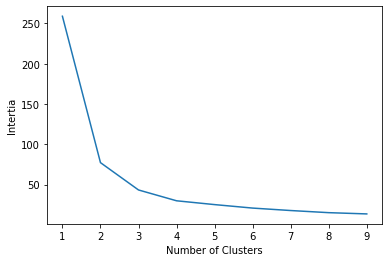

In [5]:
cluster_feature_names = [
    'recency',
    'frequency',
    'monetary_value'   
]
scaler = MinMaxScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)
cluster_elbow_method(cluster_features)

Inertia for 3 clusters: 43.39278078487819
Cluster labels - 0 = Low value customer, 2 = High value customer
Silhouette Coefficient:0.8644788508888311
Median 2nd year RLV: [ 283.12  571.31 1479.29]
Differences: [288.19, 907.98]
Value Counts:
0    791
1    960
2    996
Name: Cluster, dtype: int64
Explained variance ratio: [0.93689441 0.03653677]
Total explained variance: 0.9734311837519659


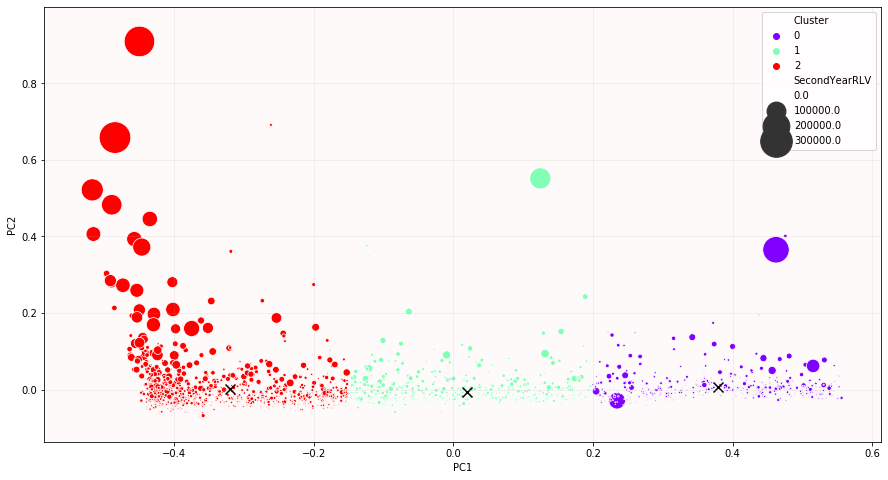

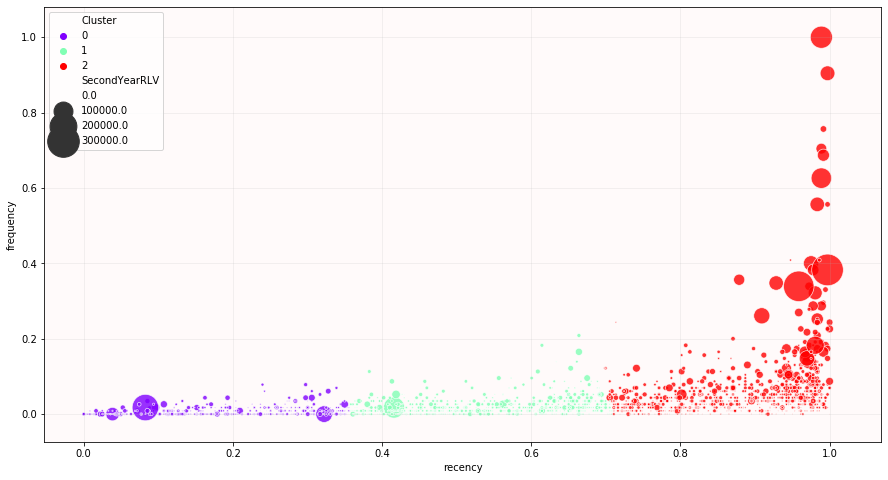

In [6]:
num_clusters = 3
cluster_features, cluster_centers  = perform_km_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [7]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=cluster_feature_names,
    index=['Component 1', 'Component 2']
)

,recency,frequency,monetary_value
Component 1,-0.996158,-0.084549,-0.022828
Component 2,-0.061160,0.485061,0.872339


<br>
<br>

**GMM**

In [8]:
cluster_feature_names = [
    'recency',
    'frequency',
    'monetary_value'   
]
scaler = MinMaxScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)

Cluster labels - 0 = Low value customer, 2 = High value customer
Silhouette Coefficient:0.7687474702471888
Median 2nd year RLV: [ 304.92  842.03 4802.18]
Differences: [537.11, 3960.15]
Value Counts:
0    1054
1    1422
2     271
Name: Cluster, dtype: int64
Explained variance ratio: [0.93689441 0.03653677]
Total explained variance: 0.9734311837519661


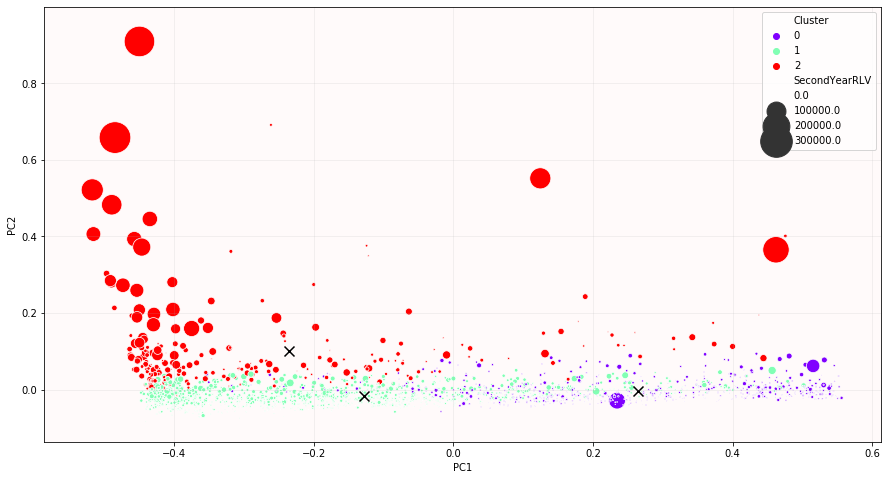

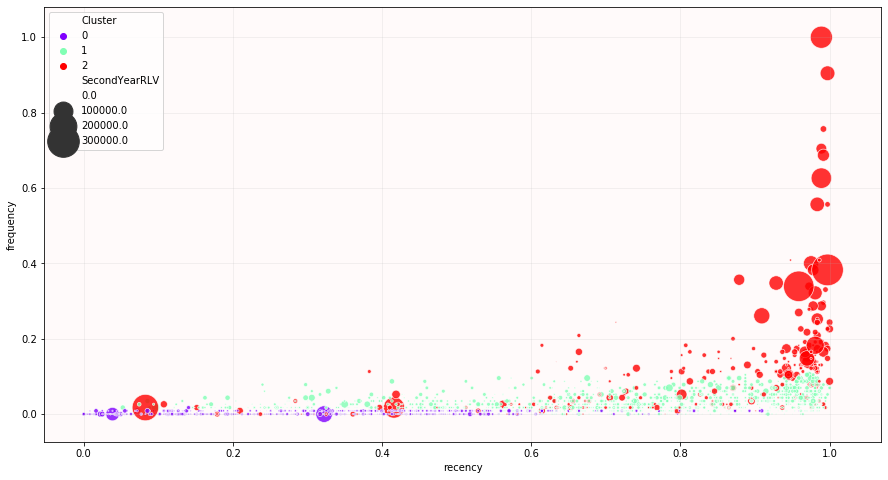

In [9]:
num_clusters = 3
cluster_features, cluster_centers, _  = perform_gmm_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [10]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=cluster_feature_names,
    index=['Component 1', 'Component 2']
)

,recency,frequency,monetary_value
Component 1,-0.996158,-0.084549,-0.022828
Component 2,-0.061160,0.485061,0.872339


<br>
<br>

# Cluster on monetary aggregation features

**KMeans**

In [11]:
features_to_transform = [
    'MedianPurchaseValue', # 'MeanPurchaseValue', 
    'StDevPurchaseValue',
    'MinPurchaseValue', 
    'MaxPurchaseValue', 
    'SumPurchaseValue',
    'SizePurchaseValue',
]
features, transformed_feature_names, yjt = transform_features(features, features_to_transform, transform="yjt")
features.head()

,yjt_MedianPurchaseValue,yjt_StDevPurchaseValue,yjt_MinPurchaseValue,yjt_MaxPurchaseValue,yjt_SumPurchaseValue,yjt_SizePurchaseValue,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
0,4.244521,5.165319,5.241102,3.481344,3.757239,0.678276,12346.0,1.0,118.0,273.0,142.310,155.0,77183.60
1,6.510838,4.747476,19.180336,4.318771,4.884639,0.678276,12349.0,1.0,182.0,215.0,1152.620,30.0,1457.55
2,4.877822,4.231502,9.981439,3.636021,4.104757,0.678276,12352.0,1.0,17.0,18.0,200.050,64.0,1385.74
3,6.226308,8.592671,13.486675,4.495430,5.008418,0.765632,12356.0,2.0,44.0,50.0,1163.905,33.0,2487.43
4,6.250493,8.010384,12.352667,4.391014,4.930844,0.765632,12358.0,2.0,356.0,357.0,544.590,1.0,928.06


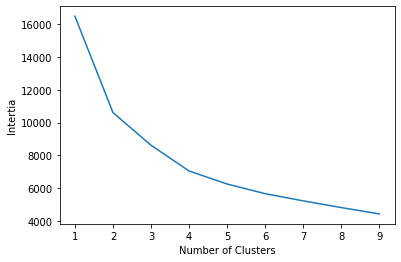

In [12]:
cluster_feature_names = transformed_feature_names
scaler = StandardScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)
cluster_elbow_method(cluster_features)

Inertia for 4 clusters: 7055.515080470864
Cluster labels - 0 = Low value customer, 3 = High value customer
Silhouette Coefficient:0.33164845936940696
Median 2nd year RLV: [ 155.24   422.64  1195.94  3035.755]
Differences: [267.4, 773.3, 1839.82]
Value Counts:
0    611
1    819
2    889
3    428
Name: Cluster, dtype: int64
Explained variance ratio: [0.60970821 0.24561132]
Total explained variance: 0.8553195290850752


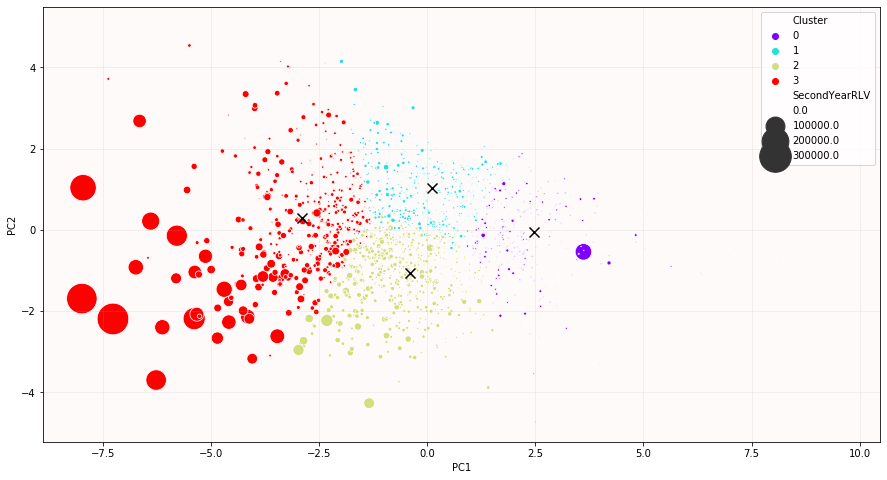

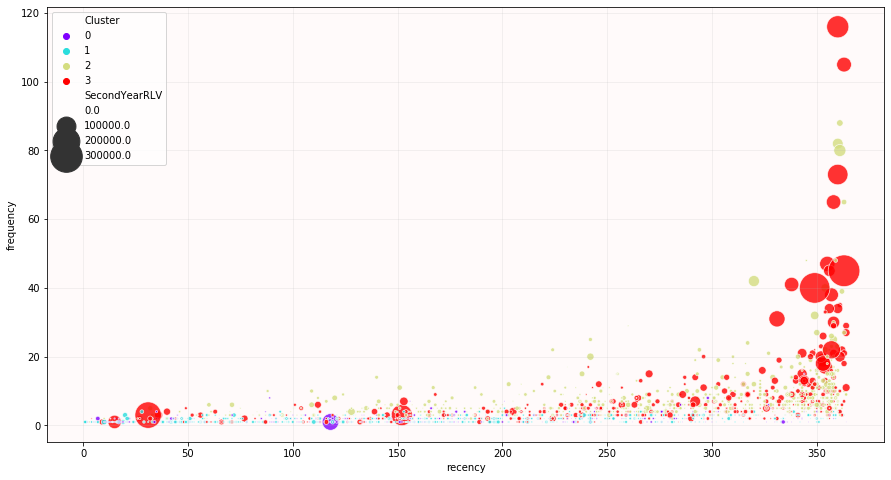

In [13]:
num_clusters = 4
cluster_features, cluster_centers  = perform_km_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [14]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=features_to_transform,
    index=['Component 1', 'Component 2']
)

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue
Component 1,-0.453231,-0.414826,-0.233350,-0.508752,-0.490940,-0.261147
Component 2,0.339336,-0.156721,0.657933,0.032912,-0.196452,-0.622685


**Pareto**

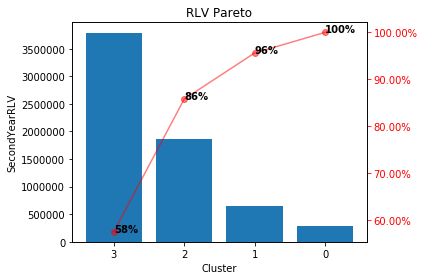

In [15]:
pareto_df = cluster_features.groupby('Cluster')['SecondYearRLV'].sum().reset_index()
pareto_df['Cluster'] = pareto_df['Cluster'].astype(str)
pareto_plot(pareto_df, x='Cluster', y='SecondYearRLV', show_pct_y=True, title='RLV Pareto')

<br>
<br>

**GMM**

In [16]:
cluster_feature_names = transformed_feature_names
scaler = StandardScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)

Cluster labels - 0 = Low value customer, 3 = High value customer
Silhouette Coefficient:0.1353706769213861
Median 2nd year RLV: [ 214.485  686.915  950.93  1836.215]
Differences: [472.43, 264.01, 885.29]
Value Counts:
0     792
1     394
2    1033
3     528
Name: Cluster, dtype: int64
Explained variance ratio: [0.60970821 0.24561132]
Total explained variance: 0.8553195290850745


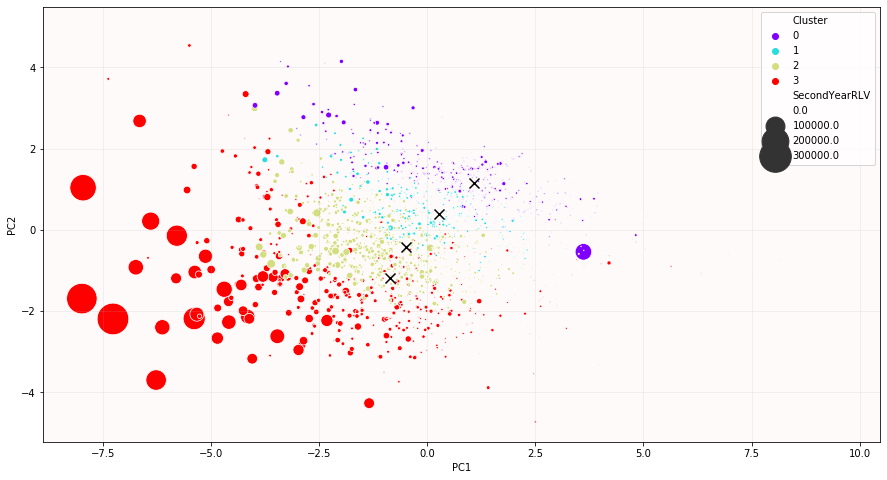

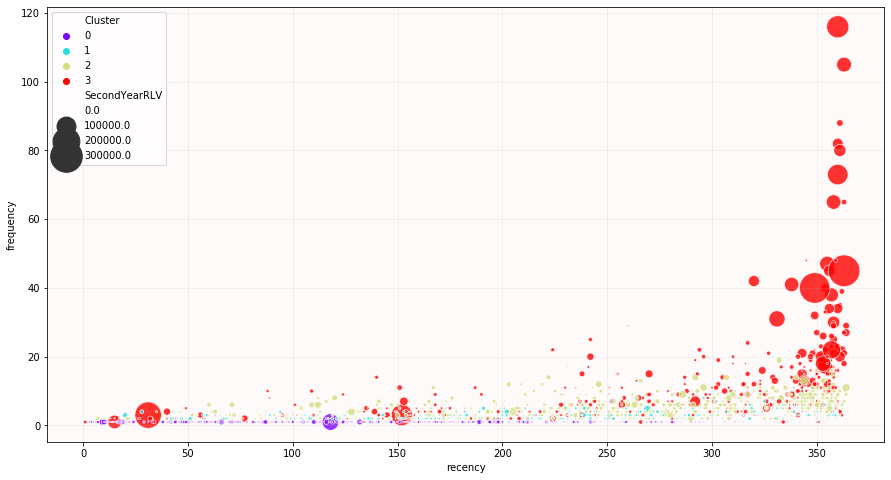

In [17]:
num_clusters = 4
cluster_features, cluster_centers, _  = perform_gmm_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [18]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=features_to_transform,
    index=['Component 1', 'Component 2']
)

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue
Component 1,-0.453231,-0.414826,-0.233350,-0.508752,-0.490940,-0.261147
Component 2,0.339336,-0.156721,0.657933,0.032912,-0.196452,-0.622685


**Pareto**

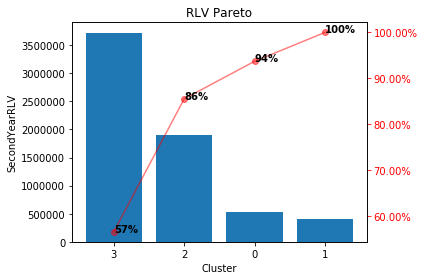

In [19]:
pareto_df = cluster_features.groupby('Cluster')['SecondYearRLV'].sum().reset_index()
pareto_df['Cluster'] = pareto_df['Cluster'].astype(str)
pareto_plot(pareto_df, x='Cluster', y='SecondYearRLV', show_pct_y=True, title='RLV Pareto')

<br>
<br>

# Cluster statistics and distributions

**Mean Cluster Features**

In [20]:
features_copy = features.copy()

# Inverse transform to see cluster features
if yjt:
    features_copy.drop(columns=transformed_feature_names, inplace=True)
    features_copy = pd.concat([
        pd.DataFrame(yjt.inverse_transform(features[transformed_feature_names]), columns=features_to_transform),
        features_copy
    ], axis=1)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
else:
    for transf_col, col in zip(transformed_feature_names, features_to_transform):
        features_copy[transf_col] = np.exp(features_copy[transf_col]) - 1
        features_copy.rename(columns={transf_col:col}, inplace=True)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
features_copy.groupby("Cluster").mean()

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
Cluster,,,,,,,,,,,,,
0,365.674836,113.263471,285.585467,445.764205,731.349672,2.000000,15313.930556,1.000000,118.747475,202.304293,363.849710,85.256313,680.067386
1,362.487030,74.182185,287.861117,444.681497,1373.524239,3.829949,15430.748731,2.829949,214.771574,270.154822,366.249540,89.022843,1052.641751
2,359.879409,180.951272,196.083988,649.263059,2289.793514,5.755082,15334.727977,4.755082,242.139400,282.829622,379.130802,84.002904,1845.941404
3,558.825227,570.351499,158.166856,1779.408561,8188.678239,10.744318,15293.888258,9.744318,240.098485,288.842803,627.373811,87.350379,7047.646553


<br>
<br>

**Why transform?**

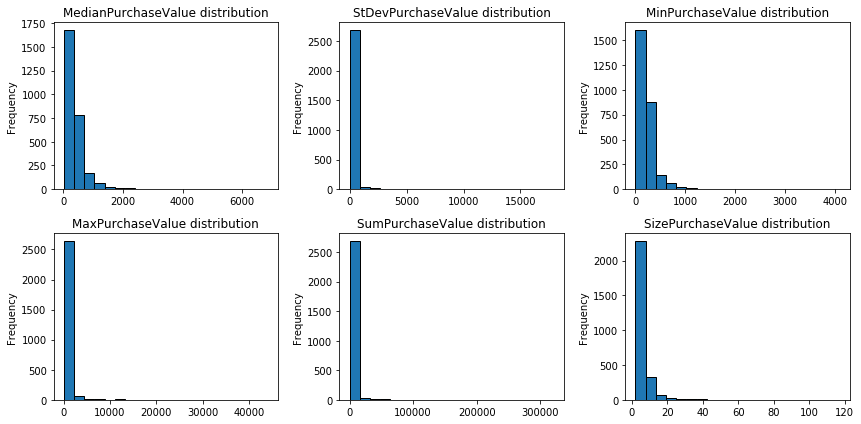

In [21]:
cluster = 0
fig = plt.figure(figsize=(12,6))
for idx, feat in enumerate(features_to_transform):
    ax = fig.add_subplot(2,3,idx+1)
    features_copy[feat].plot.hist(bins=20, ax=ax, edgecolor='k')
    ax.set_title(f"{feat} distribution")
plt.tight_layout()

Before transformation, all monetary aggregation features are right skewed. This exaggerates the difference between the highest spending customers and those who are relatively high spenders but don't spend as much. The clustering algorithms won't group these customers together unless the right side of the axis is "squashed" together which the transform seeks to achieve.

<br>
<br>

**Typical Customer**

In [22]:
closest, _ = pairwise_distances_argmin_min(cluster_centers, cluster_features[transformed_feature_names])
features_copy.iloc[closest]

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV,Cluster
1305,294.025,68.907556,245.30,342.75,588.05,2.0,15191.0,1.0,225.0,314.0,245.300000,124.0,0.00,0
1984,326.875,53.763144,270.00,397.20,1320.95,4.0,16625.0,3.0,121.0,169.0,350.316667,8.0,333.08,1
1640,332.830,161.451780,146.81,560.93,1666.63,5.0,15916.0,4.0,336.0,355.0,315.452500,6.0,1528.09,2
361,307.475,285.527877,85.90,879.64,2330.94,6.0,13213.0,5.0,185.0,194.0,407.078000,16.0,1520.58,2


In [23]:
typical_customers = features.iloc[closest].CustomerID.values
daily_customer_revenues = cohort_invoices.groupby(["CustomerID", pd.Grouper(key='InvoiceDate', freq='D')])['Revenue'].sum().reset_index()
for customer in typical_customers:
    print(daily_customer_revenues[daily_customer_revenues.CustomerID==customer].to_string(index=False))
    print()

 CustomerID InvoiceDate  Revenue
    15191.0  2010-01-20   342.75
    15191.0  2010-09-02   245.30

 CustomerID InvoiceDate  Revenue
    16625.0  2010-06-14   270.00
    16625.0  2010-08-16   310.50
    16625.0  2010-09-13   343.25
    16625.0  2010-10-13   397.20
    16625.0  2011-03-10   333.08

 CustomerID InvoiceDate  Revenue
    15916.0  2009-12-10   404.82
    15916.0  2010-01-17   146.81
    15916.0  2010-03-08   332.83
    15916.0  2010-05-30   221.24
    15916.0  2010-11-11   560.93
    15916.0  2010-12-08   232.45
    15916.0  2011-01-13   342.61
    15916.0  2011-04-07   160.12
    15916.0  2011-06-01   113.35
    15916.0  2011-09-23   118.90
    15916.0  2011-11-09   372.28
    15916.0  2011-11-23   188.38

 CustomerID InvoiceDate  Revenue
    13213.0  2010-05-20   295.55
    13213.0  2010-07-22   319.40
    13213.0  2010-10-03   549.98
    13213.0  2010-10-26   879.64
    13213.0  2010-11-11   200.47
    13213.0  2010-11-21    85.90
    13213.0  2011-05-24   415.28
    132

<br>
<br>